# Dependencies
The cell transmission model is a fairly simple model to implement and for that we only need numpy and pylab

In [3]:
import numpy
import pylab

# Introduction

There two main types of traffic flow models: microscopic - traffic modeled with each being an agent that undertakes actions based on its current situation (lane, speed, position, acceleration, etc) based on the situation of other agents on its vicinity - and macroscopic - traffic is approximated as a continuum fluid and primary variables are described as aggregated measurement such as average, density, and speed that usually are space and time dependent.

Each model class has its own weakness and strenghts. The simplicity in analyzing and implementing is the greatest advantage of macroscopic models. Especially the models based on the LWR model in which performing numerical simulations requires few lines of code. That is also the case for the cell transmission model that is presented in this notebook. 

In the LWR model, the primary variable in which we want to find $k(x,t)$ which evolves based on the following main assumptions:  

* vehicle conservation: except at entry or exits, the number of vehicles should be conserved. This principle is modeled as the following partial-differential equation:

$\frac{\partial}{\partial t}k(x,t) -\frac{\partial}{\partial x}q(x,t) = 0$

* law of continuous media: flow rate is the product of space mean speed and density:

$q(x,t) = k(x,t)v(x,t)$

* fundamental diagram: drivers set instantaneously their speed as a function of their spacing with respect to its leader given rise to a speed-spacing relationship. Using the law of continous media it become a flow-density relationship:

$q(x,t)=Q(k(x,t))$

Therefore our original partial diferential equation becomes:

$\frac{\partial}{\partial t}k(x,t) -\frac{\partial}{\partial x}Q(k(x,t)) = 0$

in which the only unkown is the density, $k(x,t)$. Despite being a somehow simple partial differential equation, most of the times it is not easy to obtain $k(x,t)$ from the input data. In that cases, we need to resort to discretizations and the cell transmission model is probably the most common discretization of the LWR model. 

In CTM, both space and time is discretized. The space is discretized into cells of equal length $\Delta x$ and time is discretized into steps of equal length $\Delta t$. The figure below depicts a schematic of link divided into N cells at time step $j$. At every time step $j$, and for every cell $i$ the flow $q(i,j)$ are computed which stands for the average flow in the interval $[j\Delta t, (j+1)\Delta t)$ and position in the interval $[i\Delta x, (i+1)\Delta x)$. In the terminolgy of the model, $q(i,j)$ is the flow leaving the cell $i$ at time step $j$. 

<img src="ctmschematic.png">

The update equation of CTM comes from the following idea:

$k(i,j+1) = k(i,j)$ + flow entering cell $i$ at step j - flow leaving cell $i$ at step j.

The flows entering and leaving in a given time step j is $q(i-1,j)$ and $q(i,j)$ respectively. The update equation becomes:

$k(i,j+1)=k(i,j) + \frac{\Delta t}{\Delta x}( q(i-1,j)-q(i,j) )$

The remaining step is how to properly compute all $q(i,j)$. Here comes the breakthrough of Cell Transmission Model compared to the earlier work. The flow $q(i,j)$ depends on the density of cell $i$ as well as the density at cell $i+1$. The computed flow must respect the following basic requirements:

* never exceed the capacity (maximum flow in the fundamental diagram)
* never lead to negative densities

CTM computes the flow the maximum flow possible that respect the above requirements through a simple methodology. For each cell $i$ two quantities at each time-step is defined:

- Demand (sending flow): the maximum flow that can travel from cell $i$ from cell $i+1$ regardless of the density at cell $i+1$, denoted as $D(i,j)$
- Supply (receiving flow): the maximum flow that cell $i$ can receive from cell $i-1$ regardless of the density at cell $i-1$, denoted as $S(i,j)$.

The flow from cell $i$ and $i+1$ is the maximum flow that does not exceed the supply of cell $i+1$ and does not exceed the demand of cell $i$ which come from the following relationship:

$q(i,j) = \min \{D(i,j),S(i+1,j) \}$

which is done for all cells from 1 to N. Further requirements is how to determine the flow at boundaries. As the flow into cell 1 would depend on the cell $0$. Same for the supply of cell $N+1$. These values usually is determined and considered as boundary conditions.

Last step is how to compute demand and supply. It has been shown that demand is the increasing part of the fundamental diagram and supply the decreasing part as shown in the Figure below.

<img src="fddemandsupply.png">

Now let's see how easy it is to code and apply CTM for different scenarios.

# Computing Demand and Supply

A first step that we need to define when using cell transmission model is the fundamental diagram that can be specific to any cell. Here let's assume a triangular fundamental diagram, the expression that defines the fundamental diagram is the following:

$Q(k)= \min \{v_f k, \omega(k_j- k)\}$
where $k$ refers to density, $v_f$ to free-flow speed, $\omega$ to shock-wave speed and $k_j$ to jam density. Here let's assume that for all cells that we are considering all these parameters are the same, but each cell has associated a number of lanes $n$ and our fundamental diagram for $n$ lanes becomes:

$Q(k,n) = \min \{v_f k, \omega(nk_j-k) \}$

For computing the increasing and decreasing part of the fundamental diagram we need to compute the capacity value, which for the triangular fundamental diagram it is as follows:

$C(n) = nk_j \frac{v_f \omega}{v_f + \omega}$

and we can compute demand and supply as follows:

$D(k,n) = \min \{v_f k, C(n) \}$ <br>
$S(k,n) = \min \{\omega(nk_j-k), C(n) \}$

So let's define Python functions for $Q$, $D$ and $S$, all the functions will also have as further inputs $v_f$, $\omega$, $k_j$, and $n$. 

In [4]:
def Q(k,n, vf, w, kj):
    return min(vf*k, w*(n*kj -k))

def D(k,n,vf, w, kj):
    return min(vf*k, n*kj*vf*w/(vf+w))

def S(k,n,vf, w, kj):
    return min(w*(n*kj-k),n*kj*vf*w/(vf+w) )

Observe these functions are simple and are the the pure translation of the previous equations. Let's assume $v_f=30$m/s, $\omega=6m/s$ and $k_j=0.1$ veh/m and plot the fundamental diagram for $n=1$ and $n=2$.

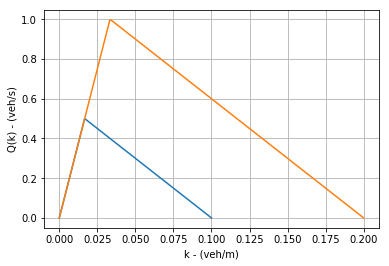

In [5]:
vf = 30
w = 6
kj=0.1

n_steps = 200

#create a vector of possible of densities
den_n1 = numpy.linspace(0, kj, n_steps)
den_n2 = numpy.linspace(0, 2*kj, n_steps)

q_1s = []
q_2s = []

#compute the flow for all densities and store in the list
for i in range(n_steps):
    q_1 = Q(den_n1[i], 1, vf, w, kj)
    q_2 = Q(den_n2[i], 2, vf, w, kj)
    
    q_1s.append(q_1)
    q_2s.append(q_2)

pylab.plot(den_n1, q_1s)
pylab.plot(den_n2, q_2s)
pylab.xlabel("k - (veh/m)")
pylab.ylabel("Q(k) - (veh/s)")
pylab.grid(True)
pylab.show()

Now let's compute demand and supply for $n=1$.

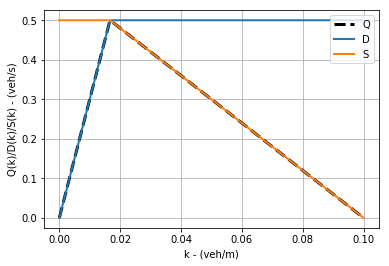

In [6]:
D_s = []
S_s = []

for i in range(n_steps):
    d = D(den_n1[i], 1, vf, w, kj)
    s = S(den_n1[i], 1, vf, w, kj)
    
    D_s.append(d)
    S_s.append(s)

pylab.plot(den_n1, q_1s,'--', color='black', linewidth=3, label='Q')
pylab.plot(den_n1, D_s,linewidth=2, label='D')
pylab.plot(den_n1, S_s,linewidth=2, label='S')
pylab.grid(True)

pylab.xlabel("k - (veh/m)")
pylab.ylabel("Q(k)/D(k)/S(k) - (veh/s)")

pylab.legend(loc=1)
pylab.show()

# Let's apply to a lane drop case

One of the most interesting scenarios in which the LWR/CTM is initiation and dissipation of congestion at bottlenecks. It often happen when there is a lane drop, that is, a road that has $n$ lanes until a location and thereafter it continues with $n-1$ lanes. The exact location in which that happens is the "bottleneck", that is, the specific location in which a congestion starts from.

In our case let's consider $\Delta t=1s$ and our cell size, $\Delta x$, should respect the following:

$\Delta x \leq v_f \Delta t$

Therefore let's use $\Delta x=30m$. For the lane drop case, we consider 20 cells (600m) of 2 lanes and another 10 cells of 1 lane. The downstream supply is always $S_{31}=0.5$ and the upstream demand as:

$D_0(j) = \begin{cases}
    0.60 veh/s, \quad j \leq 300 \\
    0.35 veh/s, \quad j > 300
\end{cases}$

The following code start all the variables for our example. Observe that is defined the number of cells and from cell 20 to 30 (index 19 to 29) there is one lane; otherwise two. Observe there is $n_cells+1$ flows to be computed.

In [8]:
total_steps = 600 #for 600s of simulation
dt = 1 #time step
dx = 30 #cell step

num_cells = 30

nc = [2 for i in range(num_cells)]

for x in range(20,30):
    nc[x] = 1
#in nc we have the number of lanes for each cell (the first 20 cells with 2 lanes, and the following 10 cels with 1 lane)

densities = numpy.zeros((num_cells, total_steps+1))
flows = numpy.zeros((num_cells+1, total_steps))

demands = [0.0 for i in range(num_cells)]
supplies = [0.0 for i in range(num_cells)]

d0 = [0.6 for j in range(total_steps)]
for j in range(300,600):
    d0[j] = 0.35
S_d = 0.5

Now we have everying set. The densities has an additional step because the flow on step $j$ changes the density in the step $j+1$. We could have define any initial density at $j=0$, but assigning as zero we are assuming empty initial conditions. 

The CTM code follows the following recipe for each time step:

* for each cell $i$ with density $k_i$, compute $D_i(k_i)$ and $S_i(k_i)$
* compute boundary flows $q_i$ as minimum of upstream demand $D_i$ and downstram supply $S_{i+1}$
* update densities on following time-step as: $k(i,j+1)=k(i,j) + \frac{\Delta t}{\Delta x}( q(i-1,j)-q(i,j) )$

The following code performs these 3 steps for all time-steps we are considering and in the end we will have our densities and flows at every cell and every time steps. Each for loop is performing each step of this recipe for all cells.

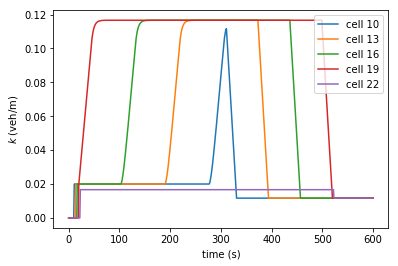

In [9]:
for j in range(total_steps):
    
    #computing demands and supplies
    for i in range(num_cells):
        n = nc[i]
        ki = densities[i,j]
        di = D(ki,n,vf,w,kj)
        si = S(ki, n, vf, w, kj)
        
        demands[i] = di
        supplies[i] = si
    
    #compute flows (observe the for over 1 additional cell, as we have N+1 flows to compute)
    for i in range(num_cells+1):
        if i==0:
            q = min(d0[j], supplies[i])
        elif i==num_cells:
            q = min(demands[i-1], S_d)
        else:
            q = min(demands[i-1], supplies[i] )
        
    
        flows[i,j] = q
    
    for i in range(num_cells):
        r = dt/dx
        
        densities[i,j+1] = densities[i,j] + r*(flows[i,j]-flows[i+1,j])

for step in range(10,25,3):
    pylab.plot(densities[step,:], label='cell '+str(step))
pylab.legend(loc=1)
pylab.xlabel("time (s)")
pylab.ylabel("$k$ (veh/m)")
pylab.show()

That's all, cell transmission model is as simple as that! But we can plot more interesting graphs. In the previous graph the density at a given cell was plotted over time. Alternatively, we can plot the density profile at certain times. The graph below show the densityes at $t=100s$, $t=300s$ and $t=450s$.

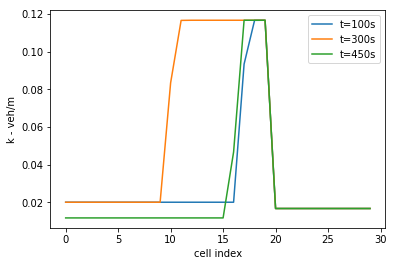

In [10]:
for t in (100, 300, 450):
    pylab.plot(densities[:,t],label="t="+str(t)+"s")

pylab.xlabel("cell index")
pylab.ylabel("k - veh/m")
pylab.legend(loc=1)
pylab.show()

So, the first graph could show the density at specific cell at all times. The second shows the density at all locations but at specific times. How about a graph that can show all information in a single plot? 

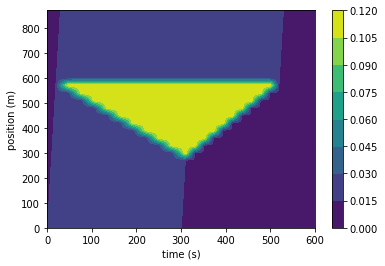

In [11]:
times = [t for t in range(total_steps+1)]
positions = [p*dx for p in range(num_cells)]

cp = pylab.contourf(times, positions, densities)
pylab.colorbar(cp)
pylab.xlabel("time (s)")
pylab.ylabel("position (m)")
pylab.show()

In purpose, the time-step is exactly 1 second here and we did not need to bother with translating time-step into time and the reverse. Nonetheless, we can increase or decrease the time-step to make or simulation more or less accurate. Just making clear the accuracy here refers to how close our results would be to the continuous LWR model with the same fundamental diagram.

The code below depict graphs for time-steps of $\Delta t=0.1$ and $\Delta t=5s$ and updaing the cell step accordingly.

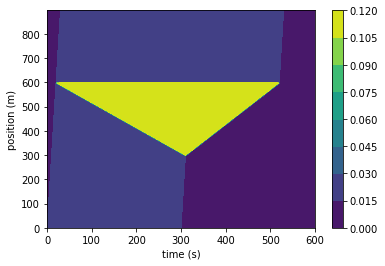

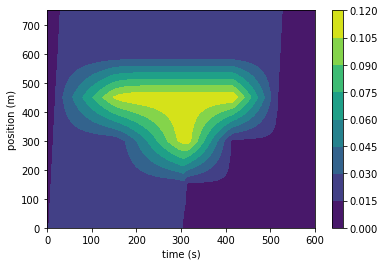

In [12]:
steps = [0.1, 5.0]

total_time = 600

for step in steps:
    total_steps = int(total_time/step)
    
    dt = step #time step
    dx = vf*step #cell step
    
    r = dt/dx

    num_cells = int(900/dx)

    nc = [2 for i in range(num_cells)]

    for x in range(int(600/dx),num_cells):
        nc[x] = 1
    #in nc we have the number of lanes for each cell (the first 20 cells with 2 lanes, and the following 10 cels with 1 lane)

    densities = numpy.zeros((num_cells, total_steps+1))
    flows = numpy.zeros((num_cells+1, total_steps))

    demands = [0.0 for i in range(num_cells)]
    supplies = [0.0 for i in range(num_cells)]

    d0 = [0.6 for j in range(total_steps)]
    for j in range(int(0.5*total_steps),total_steps):
        d0[j] = 0.35
    
    S_d = 0.5
    
    for j in range(total_steps):

        #computing demands and supplies
        for i in range(num_cells):
            n = nc[i]
            ki = densities[i,j]
            di = D(ki,n,vf,w,kj)
            si = S(ki, n, vf, w, kj)

            demands[i] = di
            supplies[i] = si

        #compute flows (observe the for over 1 additional cell, as we have N+1 flows to compute)
        for i in range(num_cells+1):
            if i==0:
                q = min(d0[j], supplies[i])
            elif i==num_cells:
                q = min(demands[i-1], S_d)
            else:
                q = min(demands[i-1], supplies[i] )


            flows[i,j] = q

        for i in range(num_cells):
            r = dt/dx

            densities[i,j+1] = densities[i,j] + r*(flows[i,j]-flows[i+1,j])
    
    times = [j*step for j in range(total_steps+1)]
    positions = [i*dx for i in range(num_cells)]


    cp = pylab.contourf(times, positions, densities)
    pylab.colorbar(cp)
    pylab.xlabel("time (s)")
    pylab.ylabel("position (m)")
    pylab.show()